In [ ]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import linear_model
import matplotlib.pylab as plt
import math
from sklearn.model_selection import train_test_split
import warnings
import seaborn as sns
from sklearn.metrics import r2_score
from scipy.stats import norm

%matplotlib inline

In [ ]:
#upload data
housing = pd.read_csv("F:/Desktop/Data/housing_value_byzip.csv")
rsl = pd.read_csv("F:/Desktop/Data/RSLTable.csv")
flood = pd.read_csv("F:/Desktop/Data/insurance2017ZIP.csv")
mortgage = pd.read_csv("F:\Desktop\Data/10_17_GroupByZip_FTNew.csv")

In [ ]:
mortgage = mortgage.rename({'ZIP':'zipcode'}, axis = 1)
mortgage

,zipcode,loan_amount_000s,reject,Applicant
0,1001,147.0,2,6
1,1002,750.0,0,1
2,1005,191.0,0,2
3,1007,157.0,1,7
4,1010,112.0,1,1
...,...,...,...,...
2071,98903,158.5,0,2
2072,98926,216.0,0,1
2073,98948,134.0,0,1
2074,98951,80.0,0,1


In [ ]:
#merge dataset
dfs = [housing, rsl, flood,mortgage]
data = dfs[0]

for df in dfs[1:]:
    data = pd.merge(data, df, left_on='zipcode', right_on = 'zipcode', how='outer')

In [ ]:
data

,zipcode,Housing_Value,seaLevelChange,distance,floodInsuranceClaimed,loan_amount_000s,reject,Applicant
0,58196,192144.733964,NaN,NaN,NaN,NaN,NaN,NaN
1,58197,309683.775167,NaN,NaN,NaN,NaN,NaN,NaN
2,58200,202440.009426,NaN,NaN,3.0,NaN,NaN,NaN
3,58201,265134.385561,NaN,NaN,89.0,NaN,NaN,NaN
4,58202,208143.260185,NaN,NaN,9.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45124,84120,NaN,NaN,NaN,NaN,223.833333,1.0,4.0
45125,84302,NaN,NaN,NaN,NaN,7.000000,0.0,1.0
45126,85305,NaN,NaN,NaN,NaN,60.000000,0.0,1.0
45127,85375,NaN,NaN,NaN,NaN,124.000000,0.0,1.0


## Data clean

In [ ]:
data = data.astype({'zipcode':'str'})

In [ ]:
data = data.loc[data['seaLevelChange']>0]

In [ ]:
df_mortgage = data[['loan_amount_000s','seaLevelChange','distance']].dropna()
df_housing = data[['Housing_Value','seaLevelChange','distance','floodInsuranceClaimed']].dropna()
df_mortgage1 = data[['reject','seaLevelChange','distance']].dropna()

In [ ]:
df_mortgage.describe()

,reject,seaLevelChange,distance
count,1071.000000,1071.000000,1071.000000
mean,0.352941,16.552528,59.662068
std,0.647488,3.605783,51.361451
min,0.000000,7.158571,1.752569
25%,0.000000,14.560000,16.083534
50%,0.000000,17.740000,41.724482
75%,1.000000,18.506250,91.517480
max,5.000000,24.656000,262.240331


In [ ]:
df_housing.describe()

,Housing_Value,seaLevelChange,distance,floodInsuranceClaimed
count,1.262000e+03,1262.000000,1262.000000,1262.000000
mean,2.052175e+05,15.735755,71.176053,118.794770
std,1.789890e+05,6.458308,54.525845,349.183993
min,1.952073e+04,4.820000,1.752569,1.000000
25%,1.087867e+05,10.085000,25.109241,2.000000
50%,1.533244e+05,14.250000,59.257235,7.000000
75%,2.320530e+05,21.244000,107.610111,54.750000
max,2.012748e+06,29.780000,360.224467,4934.000000


## Standarization

In [ ]:
#introduce a custom function performing distribution analysis
def distribution_analysis(x, log_scale = False, fit_distribution = 'None', bins = 50, vis_means = True, vis_curve = True, print_outputs = True):
    #x - array of observations
    #log_scale - analyze distribution of log(x) if True
    #fit_distribution - fit the distribution ('normal', 'gev' or 'pareto') or do nothing if 'None'
    #bins - how many bins to use for binning the data
    #vis_means - show mean and std lines if True
    #vis_curve - show interpolated distribution curve over the histogram bars if True
    #print_outputs - print mean, std and percentiles

    if log_scale:
        x1 = np.log10(x) #convert data to decimal logarithms
        xlabel = 'log(values)' #reflect in x labels
    else:
        x1 = x #leave original scale
        xlabel = 'values'
    mu = x1.mean() #compute the mean
    if log_scale: #if logscale, output all three - log mean, its original scale and original scale mean
        print('Log mean = {:.2f}({:.2f}), mean = {:.2f}'.format(mu,10**mu,x.mean()))
    else:
        print('Mean = {:.2f}'.format(mu)) #otherwise print mean
    sigma = x1.std() #compute and output standard deviation
    print('Standard deviation = {:.2f}'.format(sigma))
    for p in [1,5,25,50,75,95,99]: #output percentile values
        print('{:d} percentile = {:.2f}'.format(p,np.percentile(x,p)))

    #visualize histogram and the interpolated line (if vis_curve=True) using seaborn
    sns.distplot(x1, hist=True, kde=vis_curve,
        bins=bins,color = 'darkblue',
        hist_kws={'edgecolor':'black'},
        kde_kws={'linewidth': 4})

    #show vertical lines for mean and std if vis_means = True
    if vis_means:
        plt.axvline(mu, color='r', ls='--', lw=2.0)
        plt.axvline(mu-sigma, color='g', ls='--', lw=2.0)
        plt.axvline(mu+sigma, color='g', ls='--', lw=2.0)

    ylim = plt.gca().get_ylim() #keep the y-range of original distribution density values
    #(to make sure the fitted distribution would not affect it)

    h = np.arange(mu - 3 * sigma, mu + 3 * sigma, sigma / 100) #3-sigma visualization range for the fitted distribution
    pars = None #fitted distribution parameters

    #fit and visualize the theoretic distribution
    if fit_distribution == 'normal':
        pars = norm.fit(x1)
        plt.plot(h,norm.pdf(h,*pars),'r')
    elif fit_distribution == 'gev':
        pars = gev.fit(x1)
        plt.plot(h,gev.pdf(h,*pars),'r')
    elif fit_distribution == 'pareto':
        pars = pareto.fit(x1)
        plt.plot(h,pareto.pdf(h,*pars),'r')

    plt.xlabel(xlabel) #add x label
    plt.ylim(ylim) #restore the y-range of original distribution density values
    plt.show()
    return pars

In [ ]:
data1 = df_mortgage.copy()

In [ ]:
data1.shape

(1071, 3)

In [ ]:
for col in data1.columns:
    data1[col]=(data1[col]-data1[col].mean())/data1[col].std()
    data1 = data1.loc[(data1[col] > data1[col].mean() - 2 * data1[col].std()) & (data1[col] < data1[col].mean() + 2 * data1[col].std())]

Mean = -0.12
Standard deviation = 0.59
1 percentile = -1.06
5 percentile = -0.90
25 percentile = -0.55
50 percentile = -0.21
75 percentile = 0.20
95 percentile = 0.96
99 percentile = 1.67


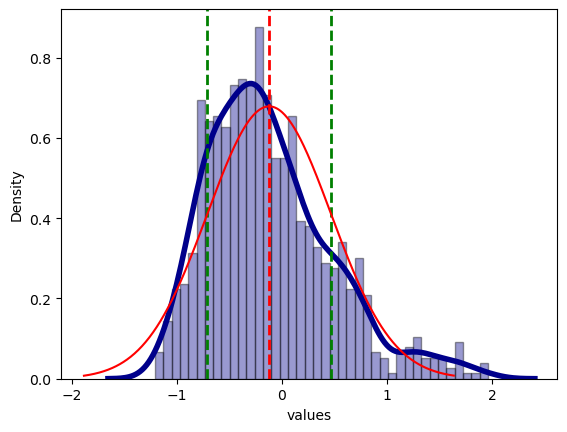

In [ ]:
distribution_analysis(data1.loan_amount_000s, fit_distribution='normal', bins=40);

In [ ]:
data11 = df_mortgage1.copy()

In [ ]:
for col in data11.columns:
    data1[col]=(data11[col]-data11[col].mean())/data11[col].std()
    data1 = data11.loc[(data11[col] > data11[col].mean() - 2 * data11[col].std()) & (data11[col] < data11[col].mean() + 2 * data11[col].std())]

In [ ]:
data2 = df_housing.copy()

In [ ]:
for col in data2.columns:
    data2[col]=(data2[col]-data2[col].mean())/data2[col].std()
    data2 = data2.loc[(data2[col] > data2[col].mean() - 2 * data2[col].std()) & (data2[col] < data2[col].mean() + 2 * data2[col].std())]

Mean = -0.15
Standard deviation = 0.56
1 percentile = -0.90
5 percentile = -0.78
25 percentile = -0.55
50 percentile = -0.31
75 percentile = 0.08
95 percentile = 1.04
99 percentile = 1.67


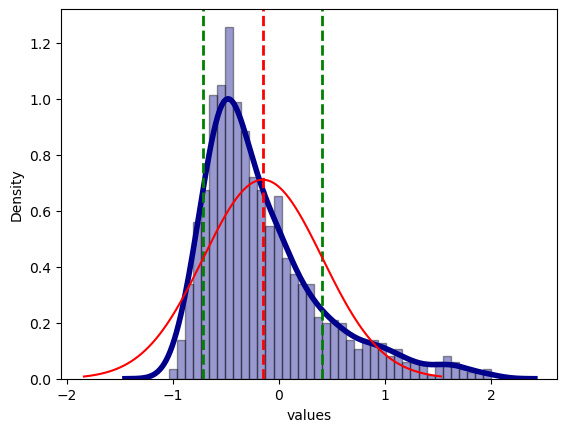

In [ ]:
distribution_analysis(data2.Housing_Value, fit_distribution='normal', bins=40);

In [ ]:
data2 = data2.loc[data2['Housing_Value']  < 0.59]

Mean = -0.30
Standard deviation = 0.35
1 percentile = -0.91
5 percentile = -0.80
25 percentile = -0.57
50 percentile = -0.37
75 percentile = -0.07
95 percentile = 0.39
99 percentile = 0.53


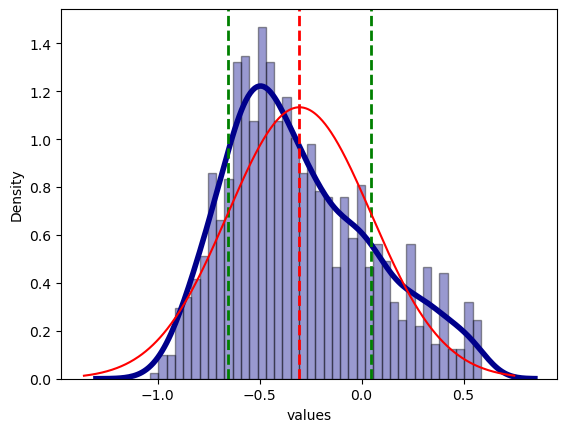

In [ ]:
distribution_analysis(data2.Housing_Value, fit_distribution='normal', bins=40);

## Divide dataset

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(data1[['seaLevelChange','distance']], data1['loan_amount_000s'], train_size=0.75)

In [ ]:
X_train11, X_test11, y_train11, y_test11 = train_test_split(data11[['seaLevelChange','distance']], data11['reject'], train_size=0.75)

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(data2[['seaLevelChange','distance','floodInsuranceClaimed']], data2['Housing_Value'], train_size=0.75)

## Liner Rrgression

In [ ]:
lm1 = smf.ols(formula='loan_amount_000s~seaLevelChange+distance', data = data1).fit()
print(lm1.summary())

                            OLS Regression Results                            
Dep. Variable:       loan_amount_000s   R-squared:                       0.047
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     23.83
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           7.92e-11
Time:                        23:30:07   Log-Likelihood:                -831.32
No. Observations:                 963   AIC:                             1669.
Df Residuals:                     960   BIC:                             1683.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1331      0.019     -7.

- The R-squared value is very low (close to 0), indicating that the model does not explain much of the variance in the dependent variable.
- None of the independent variables ('seaLevelChange', 'distance', 'floodProneDegree') seem to have a statistically significant effect on the dependent variable, as indicated by their p-values (all above 0.05).

In [ ]:
lm11 = smf.ols(formula='reject~seaLevelChange+distance', data = data11).fit()
print(lm11.summary())

                            OLS Regression Results                            
Dep. Variable:                 reject   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.666
Date:                Sun, 10 Dec 2023   Prob (F-statistic):              0.190
Time:                        23:43:24   Log-Likelihood:                -1052.0
No. Observations:                1071   AIC:                             2110.
Df Residuals:                    1068   BIC:                             2125.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2184      0.095      2.

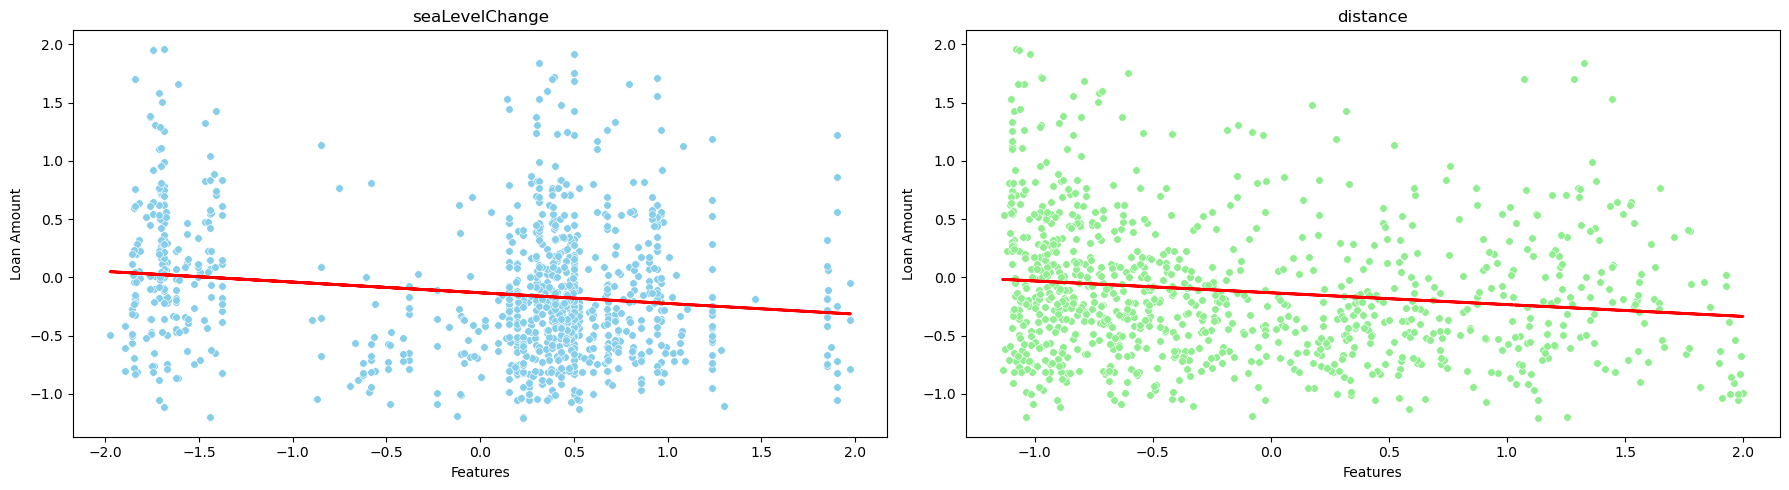

In [ ]:
# Extract the coefficients from the model
coefficients = lm1.params
intercept = coefficients['Intercept']
sea_level_change_coef = coefficients['seaLevelChange']
distance_coef = coefficients['distance']

# Create a DataFrame for visualization
data_visualize = pd.DataFrame({
    'Features': coefficients.index,
    'Coefficients': coefficients.values
})

# Create subplots for each feature
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Scatter plots with regression lines for seaLevelChange
sns.scatterplot(x='seaLevelChange', y='loan_amount_000s', data=data1, ax=axes[0],s=30,color = 'skyblue')
axes[0].plot(data1['seaLevelChange'], intercept + sea_level_change_coef * data1['seaLevelChange'], color='red', linewidth=2)
axes[0].set_title('seaLevelChange')

# Scatter plots with regression lines for distance
sns.scatterplot(x='distance', y='loan_amount_000s', data=data1, ax=axes[1],s=30,color = 'lightgreen')
axes[1].plot(data1['distance'], intercept + distance_coef * data1['distance'], color='red', linewidth=2)
axes[1].set_title('distance')

# Set common labels
for ax in axes:
    ax.set_xlabel('Features')
    ax.set_ylabel('Loan Amount')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
lm2 = smf.ols(formula='Housing_Value~seaLevelChange+distance+floodInsuranceClaimed', data = data2).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:          Housing_Value   R-squared:                       0.117
Model:                            OLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     44.11
Date:                Sun, 10 Dec 2023   Prob (F-statistic):           8.90e-27
Time:                        22:58:50   Log-Likelihood:                -315.29
No. Observations:                1007   AIC:                             638.6
Df Residuals:                    1003   BIC:                             658.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.28

- R-squared measures the proportion of the variance in the dependent variable that is predictable from the independent variables. In this case, it is 0.191, indicating that the model explains 20.1% of the variance in Housing_Value.
- The F-statistic is 88.55, and the probability associated with it is very close to zero (1.87e-51). This suggests that the model as a whole is statistically significant.

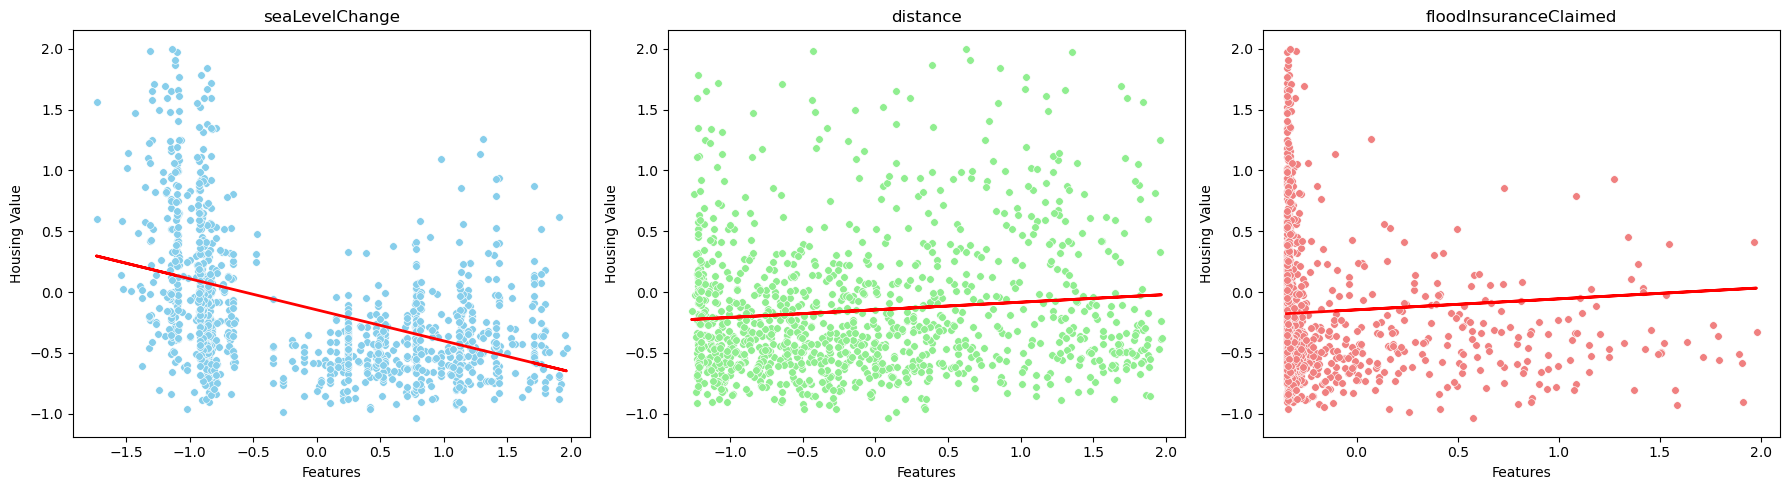

In [ ]:
# Extract the coefficients from the model
coefficients = lm2.params
intercept = coefficients['Intercept']
sea_level_change_coef = coefficients['seaLevelChange']
distance_coef = coefficients['distance']
flood_prone_degree_coef = coefficients['floodInsuranceClaimed']

# Create a DataFrame for visualization
data_visualize = pd.DataFrame({
    'Features': coefficients.index,
    'Coefficients': coefficients.values
})

# Create subplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plots with regression lines for seaLevelChange
sns.scatterplot(x='seaLevelChange', y='Housing_Value', data=data2, ax=axes[0],s=30,color = 'skyblue')
axes[0].plot(data2['seaLevelChange'], intercept + sea_level_change_coef * data2['seaLevelChange'], color='red', linewidth=2)
axes[0].set_title('seaLevelChange')

# Scatter plots with regression lines for distance
sns.scatterplot(x='distance', y='Housing_Value', data=data2, ax=axes[1],s=30,color = 'lightgreen')
axes[1].plot(data2['distance'], intercept + distance_coef * data2['distance'], color='red', linewidth=2)
axes[1].set_title('distance')

# Scatter plots with regression lines for floodProneDegree
sns.scatterplot(x='floodInsuranceClaimed', y='Housing_Value', data=data2, ax=axes[2],s=30,color = 'lightcoral')
axes[2].plot(data2['floodInsuranceClaimed'], intercept + flood_prone_degree_coef * data2['floodInsuranceClaimed'], color='red', linewidth=2)
axes[2].set_title('floodInsuranceClaimed')

# Set common labels
for ax in axes:
    ax.set_xlabel('Features')
    ax.set_ylabel('Housing Value')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
data2_Valid=data2.loc[820:]
data2_Train=data2.loc[0:820]

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Find the Alpha and report best test performance for Ridge/Lasso.
def Regularization_fit_alpha(model,X_train,y_train,X_valid,y_valid,alphas,Graph=False, logl=False):
    #model = 1-Ridge, 2-Lasso
    #alphas: a list of alpha values to try
    #Graph: plot the graph of R^2 values for different alpha

    R_2_OS=[] #out of sample R2's

    #initialize the model to use for each given alpha
    if model==1:
        RM = lambda a: linear_model.Ridge(fit_intercept=True, alpha=a)
        model_label='Ridge'
    else:
        RM = lambda a: linear_model.Lasso(fit_intercept=True, alpha=a)
        model_label='Lasso'

    best_R2 = -1
    best_alpha = alphas[0]
    best_coefs = []

    for a in alphas: #for all alphas to try
        lm = RM(a) #assign the model
        lm.fit(X_train,y_train)  #fit the regularization model
        y_predict=lm.predict(X_valid) #compute the prediction for the validation sample
        R_2_OS_=r2_score(y_valid,y_predict)
        R_2_OS.append(R_2_OS_)
        if R_2_OS_ > best_R2: #if current OS R2 is the best - update the best solution
            best_R2 = R_2_OS_
            best_alpha = a
            best_coefs = lm.coef_

    if Graph==True: #visualization of the performance depending on alpha
        plt.title('OS-R-squared for different Alpha')
        if logl: #log-scale
            plt.xlabel('ln(Alpha)')
            l=np.log(alphas)
            bl=np.log(best_alpha)
        else:
            plt.xlabel('Alpha')
            l=alphas
            bl=best_alpha
        plt.ylim((-0.1,1))
        plt.plot(l,R_2_OS,'b',label=model_label)
        plt.legend(loc='upper right')
        plt.ylabel('R-squared')
        plt.axvline(bl,color='r',linestyle='--')

        plt.show()

    return [best_alpha,best_R2,best_coefs]

In [ ]:
alphas = np.exp(np.linspace(-10,10,200)) #exponential range of possible alphas
[alpha_optimal, best_R2, best_coefs]=Regularization_fit_alpha(2,data2_Train.iloc[:,1:],data2_Train.Housing_Value,data2_Valid.iloc[:,1:],data2_Valid.Housing_Value,alphas,Graph=True,logl=True)
print('Optimal alpha for Lasso={0}, best OS R_2={1}'.format(alpha_optimal,best_R2))

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

In [ ]:
#try Lasso with arbitrary regularization parameter alpha=1
Lasso=linear_model.Lasso(fit_intercept=True, alpha=0.018876278590803843)

Lasso.fit(data2_Train.iloc[:,1:],data2_Train.Housing_Value)
# In sample:
YPred_IS=Lasso.predict(data2_Train.iloc[:,1:])
print("The IS R-squared of Lasso is: {0}".format(r2_score(data2_Train.Housing_Value,YPred_IS)))
#Out of sample
YPred_OS=Lasso.predict(data2_Valid.iloc[:,1:])
print("The OS R-squared of Lasso is: {0}".format(r2_score(data2_Valid.Housing_Value,YPred_OS)))
Lasso.coef_

ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required.

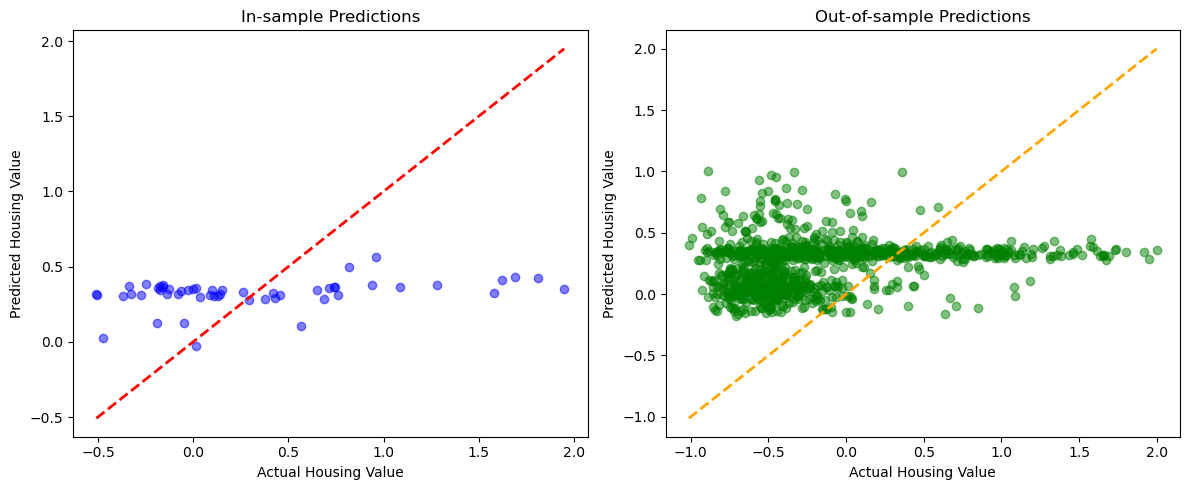

In [ ]:
# Extract the coefficients from the model
lasso_coefficients = Lasso.coef_

# Create a DataFrame for visualization
lasso_visualize = pd.DataFrame({
    'Features': data2_Train.columns[1:],
    'Coefficients': lasso_coefficients
})

# Scatter plots with Lasso predictions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# In-sample predictions
axes[0].scatter(data2_Train['Housing_Value'], YPred_IS, color='blue', alpha=0.5)
axes[0].plot([min(data2_Train['Housing_Value']), max(data2_Train['Housing_Value'])], [min(data2_Train['Housing_Value']), max(data2_Train['Housing_Value'])], color='red', linestyle='--', linewidth=2)
axes[0].set_title('In-sample Predictions')
axes[0].set_xlabel('Actual Housing Value')
axes[0].set_ylabel('Predicted Housing Value')

# Out-of-sample predictions
axes[1].scatter(data2_Valid['Housing_Value'], YPred_OS, color='green', alpha=0.5)
axes[1].plot([min(data2_Valid['Housing_Value']), max(data2_Valid['Housing_Value'])], [min(data2_Valid['Housing_Value']), max(data2_Valid['Housing_Value'])], color='orange', linestyle='--', linewidth=2)
axes[1].set_title('Out-of-sample Predictions')
axes[1].set_xlabel('Actual Housing Value')
axes[1].set_ylabel('Predicted Housing Value')

# Adjust layout
plt.tight_layout()
plt.show()

## Random Tree

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train1, y_train1)

predictions = rf_model.predict(X_test1)

mse = mean_squared_error(y_test1, predictions)
print(f'Mean Squared Error: {mse}')

feature_importances = rf_model.feature_importances_
print('Feature Importances:', feature_importances)

Mean Squared Error: 0.6880446276553771
Feature Importances: [0.40375266 0.59624734]


- MSE measures the average squared difference between predicted values and actual values. In our model, the MSE is 0.05631, which is relatively small. This indicates that the model's predictions are close to the actual values on average.
- Feature importances reveal the significance of each feature in making accurate predictions. In our model, distance has the highest importance, followed by floodInsuranceClaimed, while seaLevelChange has relatively lower importance. This insight helps understand how the model utilizes different features for prediction.


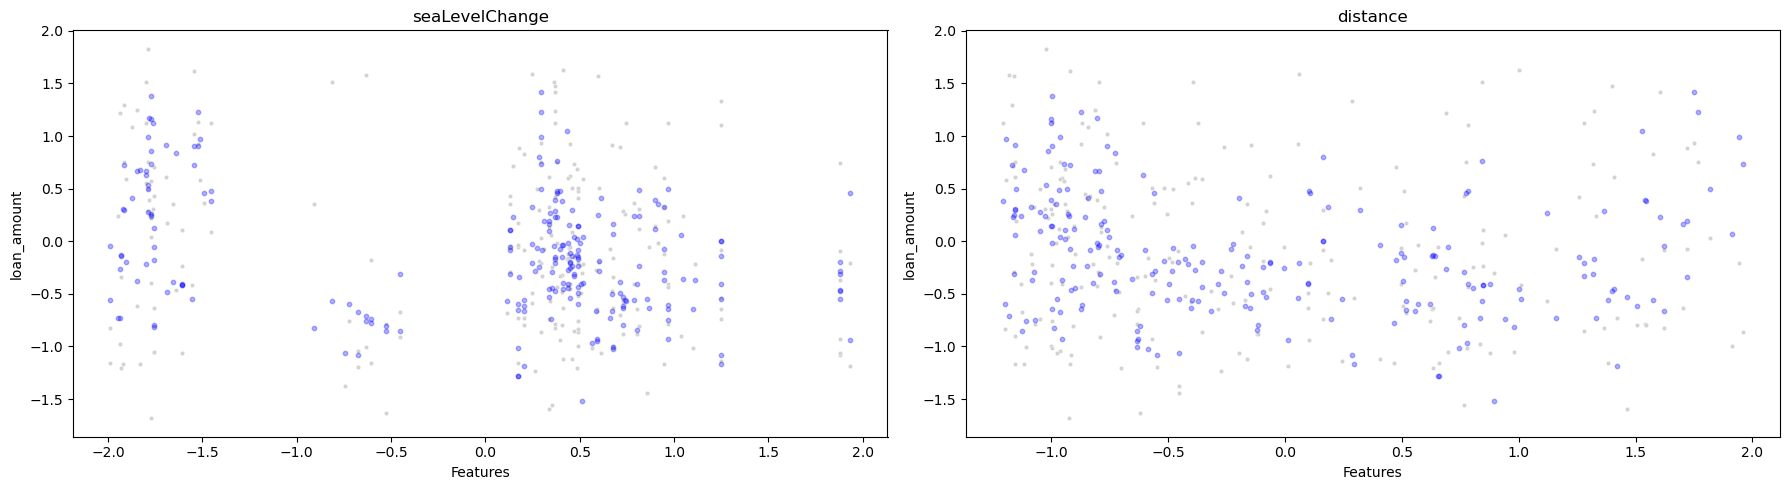

In [ ]:
features = ['seaLevelChange', 'distance']
target = 'loan_amount_000s'

# Create a DataFrame for visualization
data_visualize = pd.DataFrame({
    'Features': features,
    'Importances': feature_importances
})

# Create subplots for each feature
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Scatter plots with random forest regression lines
for i, feature in enumerate(features):
    sns.scatterplot(x=X_test1[feature], y=y_test1, ax=axes[i], color='lightgray', s=10)
    axes[i].scatter(X_test1[feature], predictions, color='blue', alpha=0.3, label='Predictions', s=10)
    axes[i].set_title(feature)

# Set common labels
for ax in axes:
    ax.set_xlabel('Features')
    ax.set_ylabel('loan_amount')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train11, y_train11)

predictions = rf_model.predict(X_test11)

mse = mean_squared_error(y_test11, predictions)
print(f'Mean Squared Error: {mse}')

feature_importances = rf_model.feature_importances_
print('Feature Importances:', feature_importances)

Mean Squared Error: 0.6502033582089553
Feature Importances: [0.30893522 0.69106478]


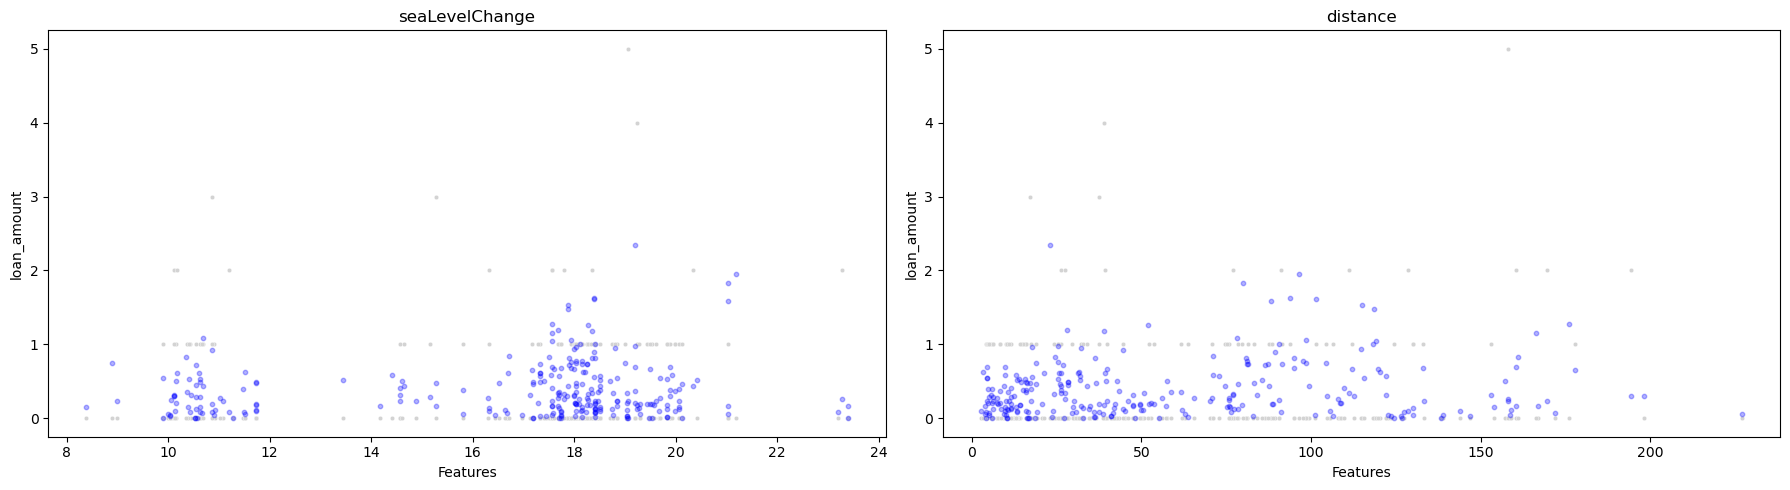

In [ ]:
features = ['seaLevelChange', 'distance']
target = 'reject'

# Create a DataFrame for visualization
data_visualize = pd.DataFrame({
    'Features': features,
    'Importances': feature_importances
})

# Create subplots for each feature
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Scatter plots with random forest regression lines
for i, feature in enumerate(features):
    sns.scatterplot(x=X_test11[feature], y=y_test11, ax=axes[i], color='lightgray', s=10)
    axes[i].scatter(X_test11[feature], predictions, color='blue', alpha=0.3, label='Predictions', s=10)
    axes[i].set_title(feature)

# Set common labels
for ax in axes:
    ax.set_xlabel('Features')
    ax.set_ylabel('loan_amount')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train2, y_train2)

predictions = rf_model.predict(X_test2)

mse = mean_squared_error(y_test2, predictions)
print(f'Mean Squared Error: {mse}')

feature_importances = rf_model.feature_importances_
print('Feature Importances:', feature_importances)

Mean Squared Error: 0.09814177685583478
Feature Importances: [0.45529297 0.35860425 0.18610278]


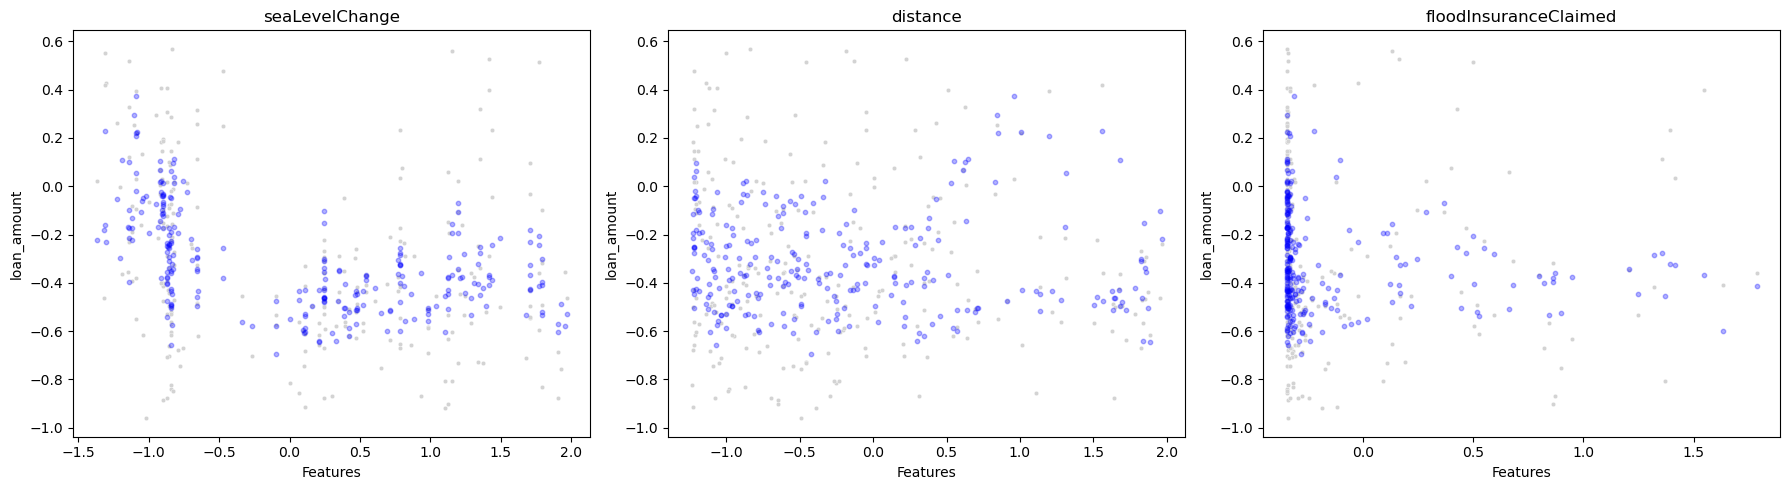

In [ ]:
features = ['seaLevelChange', 'distance', 'floodInsuranceClaimed']
target = 'Housing_Value'

# Create a DataFrame for visualization
data_visualize = pd.DataFrame({
    'Features': features,
    'Importances': feature_importances
})

# Create subplots for each feature
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Scatter plots with random forest regression lines
for i, feature in enumerate(features):
    sns.scatterplot(x=X_test2[feature], y=y_test2, ax=axes[i], color='lightgray', s=10)
    axes[i].scatter(X_test2[feature], predictions, color='blue', alpha=0.3, label='Predictions', s=10)
    axes[i].set_title(feature)

# Set common labels
for ax in axes:
    ax.set_xlabel('Features')
    ax.set_ylabel('loan_amount')

# Adjust layout
plt.tight_layout()
plt.show()

### Conclusion: chose random tree model

## Classify